## Advanced Lane Finding Pipeline

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 1. Calibrate Camera

The following code allows us to recover the calibration matrix of the camera. We only need to run it once at the beginning, since the calibration is a static feature of the lens.
We are using the 20 chessboard images that we were provided by Udacity. 


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
calibration_dir = 'camera_cal'
example_dir = 'examples'
images = [os.path.join(calibration_dir, x) for x in os.listdir(calibration_dir)]
# Step through the list and search for chessboard corners
notfound = []
notfoundname = []
image_size = (cv2.imread(images[0]).shape[0], cv2.imread(images[0]).shape[1]) 
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
    img = cv2.equalizeHist(img)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and save the corners
        corners2 = cv2.cornerSubPix(img,corners,(11,11),(-1,-1),criteria)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #cv2.imwrite(example_dir + "/drawn" +fname[22:],img)        
    else:
        notfound.append(img)
        notfoundname.append(fname)
if len(notfound) > 0:
    print("Could not find chessboard in " + str(len(notfound)) + " of the images.")
    image_string = ""
    for x in notfoundname:
        image_string += " " + x[11:] + ","
    print("These images are: " + image_string)
    
else:
    print("Sucessfully found chessboards in all the images.")
cv2.destroyAllWindows()

Could not find chessboard in 3 of the images.
These images are:  calibration5.jpg, calibration4.jpg, calibration1.jpg,


Of these 20 images, we noticed that on three of them we can not find the board. Inspecting them (images 1, 4 and 5) we notice that en each of them at least one of the chessboard corners is cropped. If we really wanted to use them, we could change the size of the chessboard to find, but instead, what we will do is use them as tests for our calibration.

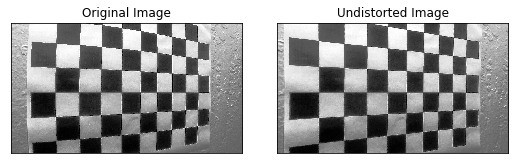

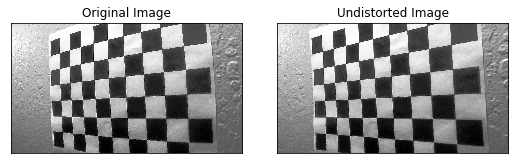

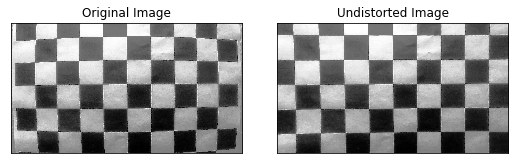

In [2]:
# Now we calibrate the camera, and 
# test with the three images we couldn't use

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
num_examples = len(notfound)


for i in range(num_examples):    
    fig = plt.figure(figsize = (18, 32))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)    
    axis = fig.add_subplot(1, 5, 1, xticks=[], yticks=[])
    axis.set_title('Original Image', fontsize=12)
    axis.imshow(notfound[i],cmap='gray')    
    undistorted = cv2.undistort(notfound[i], mtx, dist, None, mtx)
    #cv2.imwrite(example_dir + "/undistorted" +str(i)+ ".jpg",undistorted)
    axis = fig.add_subplot(1, 5, 2, xticks=[], yticks=[])
    axis.set_title('Undistorted Image', fontsize=12)
    axis.imshow(undistorted,cmap='gray')    
    plt.show()       
         

From the images above, we can immediately see the improvement we get after undistorting the original pictures. In particular, the lines look a lot more like straight lines once we apply the transformation. We are now ready for the next step

## 2. Obtain edges

In this step, we want to process the images to obtain a binary where the lanes are easy to identify and there is little else to distract away from them. 

To do so, we will use a few different techniques to isolate the pixels that are likely to define the lanes.
We will use:
* A greyscale version of the image.
* The S channel of the HLS colour representation.
* A threshold version of the HSV image.

The idea is that combining these different transformations, our lane identification will be more robust, since at least one of them might pick up the lanes.

All the code we use for going from the undistorted image to the bird's eye view of the edges can be found in Source/img_processing.py.

To pick up the likely lane pixels, we use a few different techniques. First we obtain different single channel versions of the image:
* Greyscale
* S channel from HLS
* L channel from HLS
We also obtain a fourth image using a hard coded thresholding on the HSV colour map that picks yellow and white.

After that, we applied first and second degree operators to the singel channel images (Sobel and Laplacian), as well as thresholding to the resulting images to obtain binaries.

We experimented with different combinations of the above, and settled on a Laplacian of the S channel, the Sobel on the greyscale image, and binaries for the S channel and the HSV yellow and white. We combined all of them to obtain the set of likely pixels of the lanes.


In [3]:
## Load Test images
test_dir = 'test_images'
test_images = [os.path.join(test_dir, x) for x in os.listdir(test_dir)]
test = cv2.imread(test_images[0])
len_Y, len_X = test.shape[:2]
vertices=[]

from Source import img_processing as ip

We are now ready to test out pipeline on the images provided to us in the test_images folder.

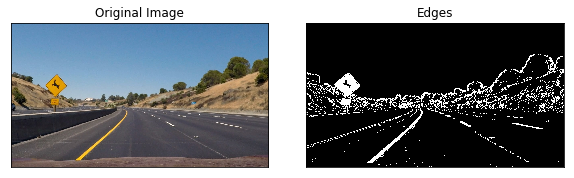

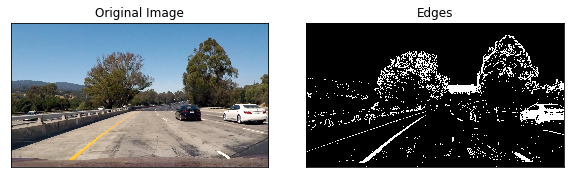

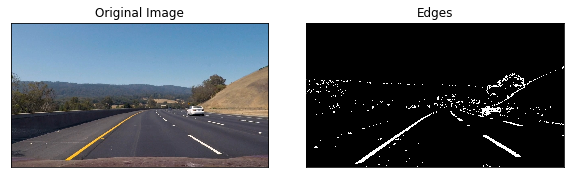

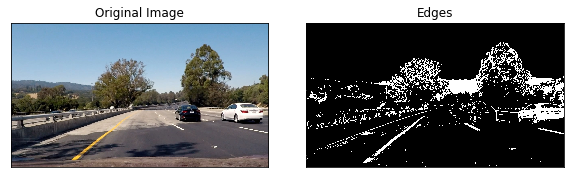

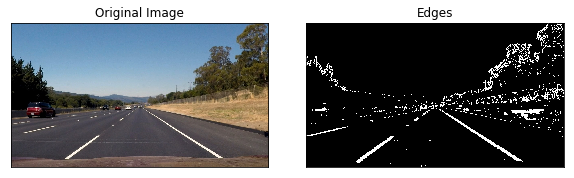

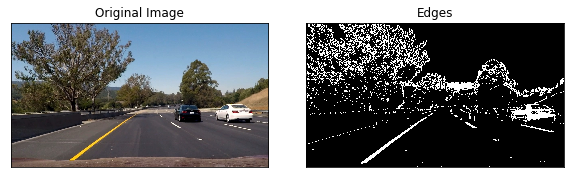

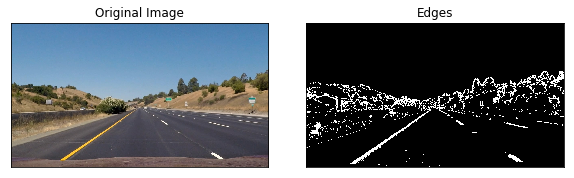

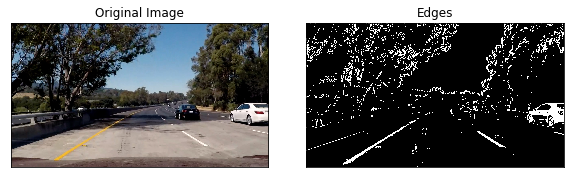

In [4]:
for fname in test_images:
    img = cv2.imread(fname)
    fig = plt.figure(figsize = (20, 30))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)    
    axis = fig.add_subplot(1, 5, 1, xticks=[], yticks=[])
    axis.set_title('Original Image', fontsize=12)
    axis.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))    
    axis = fig.add_subplot(1, 5, 2, xticks=[], yticks=[])
    axis.set_title('Edges', fontsize=12)
    the_edges = ip.obtain_edges(img, mtx, dist, vertices, 9)
    axis.imshow(the_edges, cmap='gray')      
    plt.show() 


## 3. Perspective transformation

We want to change the perspective of our images to obtain a bird's eye view of the road, since this will allow us to calculate the curvature of the road, and the position of the car with respect to the centre of the lane.
To do so, we will use one of the straight lane images available to us, and play around with the parameters of the transformation until we obtain a satisfactory result

In [5]:
## We  played around with the source and destination points

top_ = 0.44
btm_ = 0.1275
y_ = 0.65
src = np.float32([ [btm_*len_X, len_Y], [(1-btm_)*len_X, len_Y], [(1-top_)*len_X, y_*len_Y], [top_*len_X, y_*len_Y] ])
dst = np.float32([ [.2*len_X, len_Y], [(1-.2)*len_X, len_Y], [(1-.2)*len_X, 0.0], [.2*len_X, 0.0] ])

def warp_image(img, src, dst):    
    len_Y, len_X = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (len_X, len_Y))    
    return warped

def draw_lines(img, points):
    cv2.line(img, (points[0][0], points[0][1]), (points[3][0], points[3][1]), color=[0, 0, 255], thickness=2)           
    cv2.line(img, (points[1][0], points[1][1]), (points[2][0], points[2][1]), color=[0, 0, 255], thickness=2)
    return img


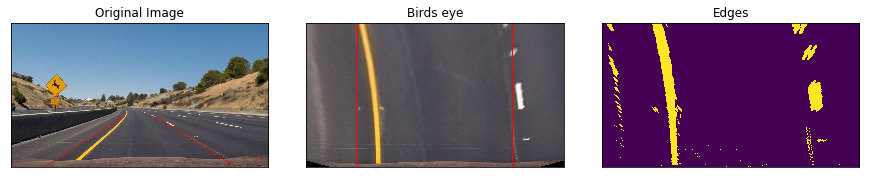

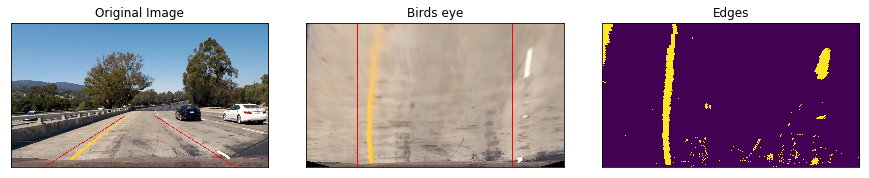

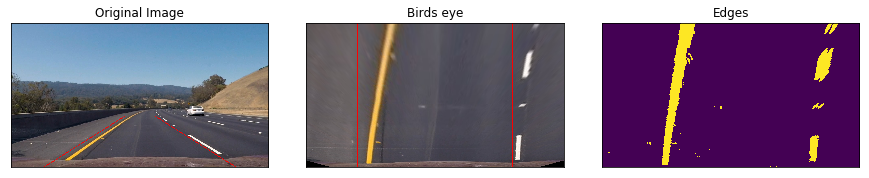

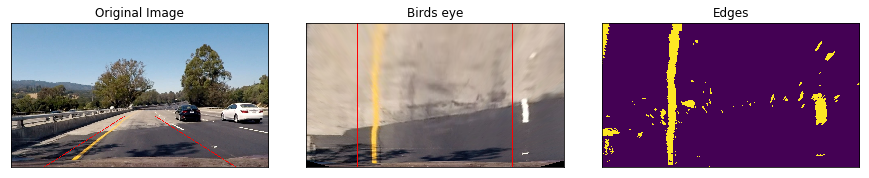

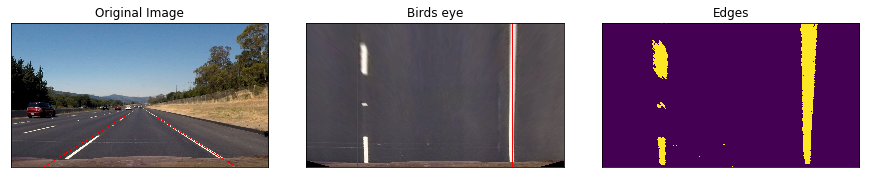

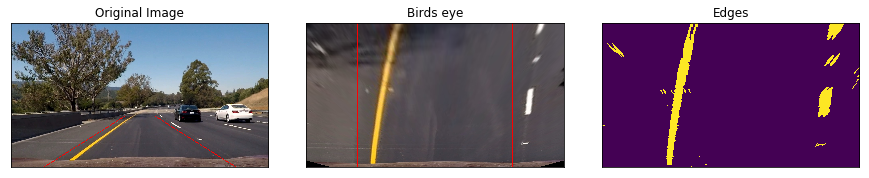

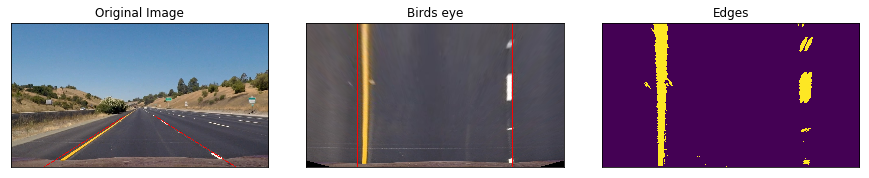

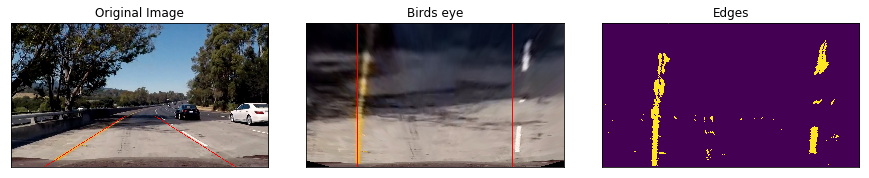

In [6]:

for fname in test_images:
    img = cv2.imread(fname)
    warp0 = ip.warp_image(img, src, dst)
    edges = ip.obtain_edges(img, mtx, dist, vertices, 9)
    warped =  ip.warp_image(edges, src, dst)    
    fig = plt.figure(figsize = (20, 30))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)    
    axis = fig.add_subplot(1, 5, 1, xticks=[], yticks=[])
    axis.set_title('Original Image', fontsize=12)
    axis.imshow(cv2.cvtColor(ip.draw_lines(img, src), cv2.COLOR_BGR2RGB))    
    axis = fig.add_subplot(1, 5, 2, xticks=[], yticks=[])
    axis.set_title('Birds eye', fontsize=12)
    axis.imshow(cv2.cvtColor(ip.draw_lines(warp0, dst), cv2.COLOR_BGR2RGB)) 
    axis = fig.add_subplot(1, 5, 3, xticks=[], yticks=[])
    axis.set_title('Edges', fontsize=12)
    axis.imshow(warped)  
    plt.show() 


## 4. Fitting a (lane) curve.

After obtaining the Bird's eye view of the likely lane pixels, it is time to try and obtain a more useful representation of the lanes. In the first project of this Nano-degree, we simply fitted a straight line. This time we will do something slightly more sophisticated.
First, we will try and identify where is the likely starting point each lane. To do so, we want to focus on the lower third of the image, and find where are the pixels concentrated.
Take the histogram of the x-coordinate of the pixels present in the lower third of the image.

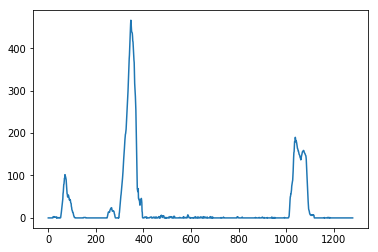

In [7]:
aux = ip.obtain_edges(test, mtx, dist, vertices, 9)
aux =  ip.warp_image(aux, src, dst)
histogram = np.sum(aux[aux.shape[0]//3:,:], axis=0)
plt.plot(histogram)

As we can see above, we are likely to identify the general location of the lane by looking at the modes of the above distribution, namely, the left hand side and right hand side modes are good starting points to look for the lanes.
Using this information, we do a sliding window search to find all the pixels that are likely to belong to the lane lines.
We draw a window around each of our initial points, and identify all the pixels that are within the window (which we colour red for the left lane and blue for the right).
The next window is drawn immediately above, and can slide left or righ if the number of pixels found is big enough, in which case the centre of the new window is taken to be the average x coordinate in the previous one.

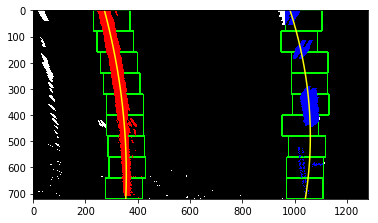

In [8]:
from Source import find_lane 
# We have recycled the code provided in the lessons
left_fit, right_fit = find_lane.from_scratch(aux, 1)

Having collected all the right hand lane and left hand lane pixels, we can now fit a curve to each of this sets, where we take y to be a function of x (because the lanes are close to vertical). The picture above illustrates both the sliding windows and th fitted curves.
Once we have identified the lanes in a frame, we expect that they will be in a similar place in the next one, and thus it is unnecessary to go through the full sliding window process again. Instead, we use the lanes (fitted curves) from the previous frame, and draw a search region around them. These regions are simply definied by applying a margin to the x-coordinate of each curve. We can then again identify all the pixels that fall under these regions, and fit new lanes for them.

(array([ -1.71369919e-04,   2.43395171e-01,   2.73608358e+02]),
 array([ -4.80469368e-04,   4.14221313e-01,   9.71812436e+02]))

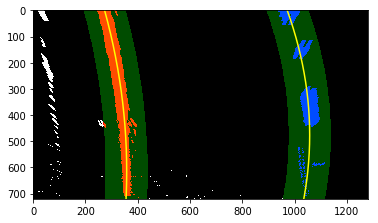

In [9]:
find_lane.from_previous(aux, left_fit, right_fit, 1)

Once we have identified the lanes, we would like to be able to visualize them in the original images.
Let's apply our pipeline to the test images to verify that our manipulations produce a sensible result.

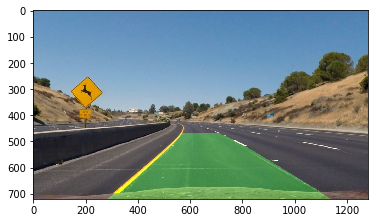

In [10]:
def plot_lane(img, left_fit, right_fit):    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    zero_ = np.zeros_like(img).astype(np.uint8)    
    
    left_fitx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image    
    lane = cv2.fillPoly(zero_, np.int32([pts]), (0,255, 0))
    #img = cv2.addWeighted(img, 1, lane, 0.3, 0)
    return lane

image = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
image = ip.undistort(image, mtx, dist)

warp0 = ip.warp_image(test, src, dst)

lane = plot_lane(warp0, left_fit, right_fit)
check1 = cv2.addWeighted(warp0, 1, lane, 0.3, 0)
u_lane = ip.warp_image(lane, dst, src)
check2 = cv2.addWeighted(image, 1, u_lane, 0.3, 0)

plt.imshow(check2)


## 5. Test on the video.

We have developed the tools to transform the image into a bird's eye view of the likely lane pixels, fitted the lane curves and drawn back the lane onto the original image. It looks like we are ready to have a go at the video.

In [11]:
import numpy as np
from collections import deque

m_per_pix_y = 30/720 # meters per pixel in y dimension
m_per_pix_x = 3.7/720 # meteres per pixel in x dimension
    

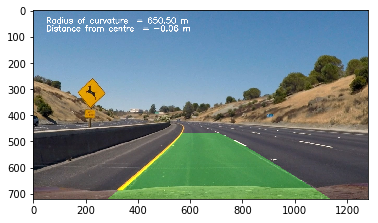

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from Source import cLane as cL

# Initialize left and right lane 
left_lane = cL.cLane(test.shape[:2])
right_lane = cL.cLane(test.shape[:2])

def process_image(image):
    # obtaind edges and bird's eye view      
    edges = ip.obtain_edges(image, mtx, dist, vertices, 9)
    warped =  ip.warp_image(edges, src, dst)
   
    try:
        left_fit, right_fit = find_lane.from_scratch(warped, 0)
        left_lane.coefficients.appendleft(left_fit)    
        right_lane.coefficients.appendleft(right_fit)
    except:
        left_fit = left_lane.averaged_fit()
        right_fit =right_lane.averaged_fit() 
    
    lane = plot_lane(image, left_fit, right_fit)
    u_lane = ip.warp_image(lane, dst, src)    
    
    final = cv2.addWeighted(image, 1, u_lane, 0.3, 0) 
    
    radius = (left_lane.compute_rad_curv() + right_lane.compute_rad_curv())/2
    
    left_camera = np.absolute((left_lane.img_size[1] // 2 - left_lane.averaged_fit()[2])) * m_per_pix_x
    right_camera = np.absolute((right_lane.img_size[1] // 2 - right_lane.averaged_fit()[2])) * m_per_pix_x
    off_centre = (right_camera - left_camera)/2
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    if radius > 2500:
        cv2.putText(final,'Mostly straight',(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(final,'Radius of curvature  = %.2f m'%(radius),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        
    cv2.putText(final,'Distance from centre  = %.2f m'%(off_centre),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return final

plt.imshow(cv2.cvtColor(process_image(test), cv2.COLOR_BGR2RGB))

In [13]:
video_output = 'Output/first_video_test.mp4'

clip1 = VideoFileClip("Videos/project_video.mp4").subclip(45,49)
#clip1 = VideoFileClip("Videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video Output/first_video_test.mp4
[MoviePy] Writing video Output/first_video_test.mp4


 99%|█████████▉| 100/101 [00:26<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output/first_video_test.mp4 

CPU times: user 52.2 s, sys: 408 ms, total: 52.6 s
Wall time: 28.4 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))